In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stripROtools
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import crystalball

from stripROtools import colors
from stripROtools import GetTransErrs
from stripROtools import gaus2
from stripROtools import Mismeasurment_vs_z
from stripROtools import set_axes_equal
from stripROtools import random_three_vector
from stripROtools import plot_track

# Read dE/dx data from SRIM

In [2]:
# Load dEdx data simulated with SRIM
dEdx_data = np.loadtxt("./data/srim_po210_heco2.txt",skiprows=4)

dEdx_data = dEdx_data.T

# convert from angstrom to cm
dEdx_data[0] = dEdx_data[0]*1e-8

#dEdx resolution as seen in dEdx_data[0] 
delta_x = 0.1

# convert to eV/cm
dEdx_data[1] = dEdx_data[1]/1e-8
dEdx_data[2] = dEdx_data[2]/1e-8

dEdx = dEdx_data[1] + dEdx_data[2]




# Simulate Po210 alpha tracks

In [3]:
# The paramters, in order, are:
# number of simulations
# minimum angle to vertical [degrees] - this is based  on requiring a min. of 5 hits
# maximum angle to vertical [degrees]
# drfit length [cm]
# Apply diffusion T/F
# Transverse diffusion coefficent from Magboltz [cm/sqrt(cm)]
# W-value as obtained using degrad

def sim_p210(n_sims = 500, theta_min = 5.0, theta_max = 25.0, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2):

    tracks = pd.DataFrame(columns = ['direction', 'start', 'track'])

    for i in range(n_sims):

        # draw a random direction within specified solid angle (pointing down towards the readout plane)
        v = random_three_vector(theta_min,theta_max)

        # Maximumm track length of alpha track
        L_max = -DL/v[2]

        # Length segments we will distribute charge on, 0.1 is the resolution of length of the SRIM simulation
        L_segments = np.arange(0,L_max,0.1)

        # Edges of the length segments we will distribute charge on (all edges are listed)
        L_edges = np.append(L_segments,L_max)

        # Energy deposited in each segment given dEdx (energy in each bin is listed)
        E_segments = dEdx[0:len(L_segments)]*np.diff(L_edges)

        # Compute corresponding number of ionizaed eletrons using energy deposited per segment divided by W-value
        Ne_segments = np.round(E_segments/W).astype("int")

        #find left and right edges for each bin
        Left_edges = L_segments[0:-1]
        Right_edges = L_segments[1:]

        track = np.empty((0,3))

        for N,left_edge,right_edge in zip(Ne_segments,Left_edges,Right_edges):

            Ts = np.random.uniform(low=left_edge,high=right_edge,size=N)

            if Diff == False:

                x_vals = Ts*v[0]
                y_vals = Ts*v[1]
                z_vals = DL + Ts*v[2]

                Track_segment = np.array([x_vals,y_vals,z_vals]).T

                track = np.append(track,Track_segment,axis=0)
            
            elif Diff == True:

                z_vals = DL + Ts*v[2]

                x_vals = Ts*v[0] + DTrans*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))
                y_vals = Ts*v[1] + DTrans*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))
                z_vals = z_vals + DLong*np.sqrt(np.abs(z_vals))*np.random.normal(size=len(Ts))

                Track_segment = np.array([x_vals,y_vals,z_vals]).T

                track = np.append(track,Track_segment,axis=0)

        x_rand = np.random.uniform()-0.5
        y_rand = np.random.uniform()-0.5

        track[:,0] = track[:,0]+x_rand # randomize x position (1 cm random uniform dist)
        track[:,1] = track[:,1]+y_rand # randomize x position (1 cm random uniform dist)

        tracks = tracks.append({'direction' : v, 'start' : np.array([x_rand,y_rand,DL]), 'track' : track }, ignore_index = True)

    return tracks




In [4]:
tracks = sim_p210(n_sims = 100)
tracks.head()

,direction,start,track
0,"[-0.30281719327026135, -0.10819167743677302, -...","[-0.2517415794121307, 0.05163724510145051, 1.2]","[[-0.2906174545959596, 0.04421520654786457, 1...."
1,"[0.08075609705941707, 0.06493245176927616, -0....","[0.34720419954020254, 0.41172925421120876, 1.2]","[[0.37101242715248167, 0.4239195969810416, 1.1..."
2,"[0.24250135959518002, -0.2688739676853691, -0....","[0.1432642855880476, -0.22709942036794473, 1.2]","[[0.11209230483039573, -0.24050759687853887, 1..."
3,"[0.11922298004184899, -0.35439229076615114, -0...","[-0.2815156350700537, -0.20331380532759624, 1.2]","[[-0.2626052173271502, -0.2140177575300092, 1...."
4,"[-0.19501056133150244, -0.15066307011148908, -...","[0.4852461460316789, 0.35972169887513783, 1.2]","[[0.46558566032717874, 0.36563287089907737, 1...."


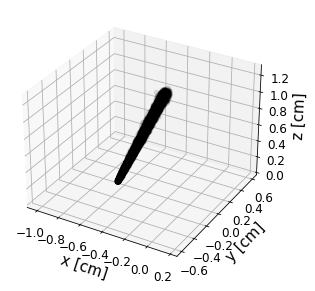

In [5]:
# Plot a Track
index = 0
track = tracks.iloc[index]["track"]
plot_track(track)

# Simulate readout


In [6]:
# the parameters, in order, are:
# peaking time [ns]
# digitization time [ns] 
# pitch of the x strips [cm]
# pitch of the y strips [cm]
# Threshold of x strips [No. electrons]
# Threshold of y strips [No. electrons]
# Charge sharing [lower strips / upper strips]
# Gain - extrapolating from PHA curve
# drift speed cm/ns
# Include charge integration effect.
# z resolution in cm, must be specified if Charge_integration = False

def sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = 0.02, pitch_y = 0.02,thres_x = 82/9.0*6241.5, thres_y =  82/4.5*6241.5, CS = 0.62, Gain = 505.7, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02):

    # Readout is 10 cm x 10 cm
    x_bins = np.arange(-5,5,pitch_x)
    y_bins = np.arange(-5,5,pitch_y)

    # Find strip edges in x and y
    Left_edges_x = x_bins[0:-1]
    Right_edges_x = x_bins[1:]
    Left_edges_y = y_bins[0:-1]
    Right_edges_y = y_bins[1:]


    hits = pd.DataFrame(columns = ['strips_x', 'strips_y', 'times_x', 'times_y','electrons_x','electrons_y'])

    for index, row in tracks.iterrows():

        track = row.track

        x_positions = []
        x_charges = []
        x_times = []

        for L_edge,R_edge in zip(Left_edges_x,Right_edges_x):

            # Bin track over specific strip in x
            T_track = track[(track[:,0]> L_edge) &  (track[:,0]< R_edge)]

            # If there is charge above this strip
            if len(T_track > 0):


                # If we are incuding the effects of finite charge integration time followed by digitization time
                if Charge_integration == True:

                    # Get time distribution of charge over this strip
                    time_dist = T_track[:,2]/v_drift

                    # Shift so that min is t = 0ns
                    min_time = np.min(time_dist)
                    time_dist= time_dist-min_time

                    # Keeping only the charge withing peaking time
                    time_dist = time_dist [time_dist < peaking_time]

                    # compute mean time for the hit
                    mean_time = np.mean(time_dist)+min_time

                    # obtain detected charge taking into account primary ionization, gain, and charge sharing
                    charge_detected = len(time_dist) *Gain * CS / (CS+1.0)

                    if charge_detected > thres_x:
                        
                        # obtain mean time for the hit
                        x_times += [mean_time]
                        # obtain position of the hit
                        x_positions += [ (L_edge+R_edge)/2.0 ]
                        # obtain detected charge taking into account primary ionization, gain, and charge sharing
                        x_charges += [ charge_detected ]

                # Otherwise we bin the time axis according to the specified z resolution
                else:

                    # Bin in the z-dimension
                    z_bins = np.arange(0,1.2+pitch_z,pitch_z)
                    hist, bin_edges = np.histogram(T_track[:,2],bins=z_bins)
                    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

                    bin_centers = bin_centers[hist>0]
                    hist = hist[hist>0]

                    charge_detected = hist *Gain * CS / (CS+1.0)

                    # only keep hits above threshol
                    bin_centers = bin_centers[charge_detected>thres_x]
                    charge_detected = charge_detected [charge_detected>thres_x]


                    x_times += list(bin_centers/v_drift)
                    x_positions += list( np.ones(len(bin_centers)) * ((L_edge+R_edge)/2.0) )
                    x_charges += list(charge_detected)

        

        y_positions = []
        y_charges = []
        y_times = []

        for L_edge,R_edge in zip(Left_edges_y,Right_edges_y):

            # Bin track over specific strip in x
            T_track = track[(track[:,1]> L_edge) &  (track[:,1]< R_edge)]

            # If there is charge above this strip
            if len(T_track > 0):

                # If we are incuding the effects of finite charge integration time followed by digitization time
                if Charge_integration == True:

                    # Get time distribution of charge over this strip
                    time_dist = T_track[:,2]/v_drift

                    # Shift so that min is t = 0ns
                    min_time = np.min(time_dist)
                    time_dist= time_dist-min_time

                    # Keeping only the charge withing peaking time
                    time_dist = time_dist [time_dist < peaking_time]

                    # compute mean time for the hit
                    mean_time = np.mean(time_dist)+min_time

                    # obtain detected charge taking into account primary ionization, gain, and charge sharing
                    charge_detected = len(time_dist) * Gain / (CS+1.0)

                    if charge_detected > thres_y:

                        # obtain mean time for the hit
                        y_times += [mean_time]
                        # obtain position of the hit
                        y_positions += [ (L_edge+R_edge)/2.0 ]
                        # obtain detected charge taking into account primary ionization, gain, and charge sharing
                        y_charges += [ charge_detected ]

                # Otherwise we bin the time axis according to the specified z resolution
                else:

                    # Bin in the z-dimension
                    z_bins = np.arange(0,1.2+pitch_z,pitch_z)
                    hist, bin_edges = np.histogram(T_track[:,2],bins=z_bins)
                    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

                    bin_centers = bin_centers[hist>0]
                    hist = hist[hist>0]

                    charge_detected = hist * Gain / (CS+1.0)

                    # only keep hits above threshol
                    bin_centers = bin_centers[charge_detected>thres_y]
                    charge_detected = charge_detected [charge_detected>thres_y]


                    y_times += list(bin_centers/v_drift)
                    y_positions += list( np.ones(len(bin_centers)) * ((L_edge+R_edge)/2.0) )
                    y_charges += list(charge_detected)

        hits = hits.append({'strips_x' : np.array(x_positions), 'strips_y' : np.array(y_positions), 'times_x' : np.array(x_times), 'times_y' : np.array(y_times), 'electrons_x' :  np.array(x_charges), 'electrons_y' : np.array(y_charges) }, ignore_index = True)
        
    return hits


In [7]:
hits = sim_readout(tracks)
tracks = pd.concat([tracks,hits],axis=1)
tracks.head()


,direction,start,track,strips_x,strips_y,times_x,times_y,electrons_x,electrons_y
0,"[-0.30281719327026135, -0.10819167743677302, -...","[-0.2517415794121307, 0.05163724510145051, 1.2]","[[-0.2906174545959596, 0.04421520654786457, 1....","[-0.6100000000000936, -0.590000000000094, -0.5...","[-0.07000000000010509, -0.050000000000105516]","[112.4201158402777, 177.91299560641193, 256.99...","[171.4811452655253, 285.9783989433088]","[151347.89382716047, 201668.16543209876, 20728...","[673954.5061728394, 262526.97530864197]"
1,"[0.08075609705941707, 0.06493245176927616, -0....","[0.34720419954020254, 0.41172925421120876, 1.2]","[[0.37101242715248167, 0.4239195969810416, 1.1...","[0.4099999999998847, 0.42999999999988425, 0.44...","[0.4699999999998834, 0.489999999999883]","[316.96769837415377, 142.6572510390405, 62.567...","[195.60845212611432, 94.35427618153405]","[82060.75061728395, 327662.3839506173, 189475....","[271267.4691358025, 640241.1728395061]"
2,"[0.24250135959518002, -0.2688739676853691, -0....","[0.1432642855880476, -0.22709942036794473, 1.2]","[[0.11209230483039573, -0.24050759687853887, 1...","[0.14999999999989022, 0.1699999999998898, 0.18...","[-0.5500000000000949, -0.5300000000000953, -0....","[1389.6702214126983, 1306.6692312728637, 1217....","[127.69845982287413, 190.2192738411763, 275.78...","[82447.82962962962, 100059.92469135803, 117284...","[186047.65432098764, 358984.56790123455, 37178..."
3,"[0.11922298004184899, -0.35439229076615114, -0...","[-0.2815156350700537, -0.20331380532759624, 1.2]","[[-0.2626052173271502, -0.2140177575300092, 1....","[-0.2100000000001021, -0.19000000000010253, -0...","[-0.6300000000000932, -0.6100000000000936, -0....","[648.187662307669, 484.4177466330576, 331.1786...","[127.517564815179, 170.8784091885684, 235.5589...","[85738.0012345679, 103350.09629629628, 174766....","[126424.99999999999, 266897.2222222222, 287811..."
4,"[-0.19501056133150244, -0.15066307011148908, -...","[0.4852461460316789, 0.35972169887513783, 1.2]","[[0.46558566032717874, 0.36563287089907737, 1....","[0.2499999999998881, 0.26999999999988766, 0.28...","[0.18999999999988937, 0.20999999999988894, 0.2...","[80.2690933992955, 163.79116605093614, 277.398...","[139.13554691696362, 264.06502257144115, 377.2...","[141283.83950617284, 304244.10370370373, 26108...","[602469.7530864197, 412051.8518518518, 196036...."


# Perform 3D Reconstruction

In [8]:
# enter reconstruction parameters here

def Reconst3D_v1 (strips_x,strips_y,times_x,times_y,electrons_x,electrons_y,start,direction, v_drift = 0.0008, mu = -6.7, sigma = 16.4 , n_sigma = 3, plot = True, save_name = None,plot_truth = False ):
    # This 3D reconstruction algorithim only matches x and y hits if they are within a time window specified by mu, sigma, n_sigma
    # After x and y hits are matched, the x ADCs are spread evenly among all matched y hits and vice versa
    # The time is the average of the x hit time and y hit time
    # Unmatched hits are spread along all matched vertices via a time-weighted spread

    # Truth array - contains truth value for x and y hits that fire within the time gap window.
    # i.e. if Tarray_{ij} = True, then the ith x hit and the jth y hit are within the gap window
    # and should be combined, this constitutes an xy-hit
    Tarray = np.abs((np.subtract.outer(times_x,times_y)-mu) / sigma) < n_sigma

    # This counts the number of simultaniously triggering y hits for each x hit
    TCol = np.sum(Tarray,axis=1)*1.0
    # This counts the number of simultaniously triggering x hits for each y hit
    TRow = np.sum(Tarray,axis=0)*1.0
            
    # Throw an error if there are unmatched hits
    # This can be updated later
    if (0 in TCol) or (0 in TRow):
        print("Warning: Unmatched hits. Performing time-weighted spread")

    # Collect unmatched hit info
    # Convert ADC to electron count units
    unmatched_ADCs = np.append(electrons_x[ TCol == 0 ], electrons_y[ TRow == 0 ])
    # Shift x and y times based on mean offset
    unmatched_times = np.append( times_x[ TCol == 0 ] - (mu/2.0) ,  times_y[ TRow == 0 ] + (mu/2.0) )

    # Rebuild arrays, ommiting unmatched hits
    # Convert ADC to electron count units
    x_times = times_x[ TCol > 0 ]
    ADC_x = electrons_x[ TCol > 0 ]
    strips_x = strips_x[ TCol > 0 ]
    y_times = times_y[ TRow > 0 ]
    ADC_y = electrons_y[ TRow > 0 ] 
    strips_y = strips_y[ TRow > 0 ]
    Tarray = np.abs((np.subtract.outer(x_times,y_times)-mu) / sigma) < n_sigma
    TCol = np.sum(Tarray,axis=1)*1.0
    TRow = np.sum(Tarray,axis=0)*1.0

    # This divides the ADC of the x hit by the number of simultaniously triggering y hits
    ADCx_V = np.divide(ADC_x,TCol)

    # This is a matrix of the x ADC contribution to all xy-hits
    elecx_M = np.multiply(ADCx_V[..., None],Tarray)

    # This divides the ADC of the y hit by the number of simultaniously triggering x hits
    ADCy_V = np.divide(ADC_y,TRow)

    # This is a matrix of the y ADC contribution to all xy-hits
    elecy_M = np.multiply(ADCy_V,Tarray)

    # This is the total ADC assigned to each xy-hit
    elec_M = elecx_M+elecy_M

    # This holds the x strip position for each xy-hit
    Stripx_M = np.multiply(strips_x[..., None],Tarray)

    # This holds the y strip position for each xy-hit
    Stripy_M = np.multiply(strips_y,Tarray)

    # This holds the x time measurment for each xy-hit
    Timex_M = np.multiply(x_times[..., None],Tarray)

    # This holds the y time measurment for each xy-hit
    Timey_M = np.multiply(y_times,Tarray)

    # This holds the average time measurment for each xy-hit
    Time_M = (Timex_M + Timey_M) / 2.0

    # absolute time offsets between matched vertices and unmatched hits
    abs_t_off = np.abs( Time_M-np.tensordot(unmatched_times, Tarray, axes=0) )
    # Really we want to weight by the inverse time difference 
    abs_t_off = np.reciprocal(abs_t_off,where= abs_t_off!=0)

    # Corresponding umatched ADC and time offset normalization factor
    ADC_norm = unmatched_ADCs/abs_t_off.sum(axis=1).sum(axis=1)

    # Multiply togather and sum to get total unmatched ADC contribution for each vertex
    unmatched_contrib = (abs_t_off*np.tensordot(ADC_norm, Tarray, axes=0)).sum(axis=0)

    # Add to ADC matrix
    elec_M += unmatched_contrib


    x_vals = Stripx_M[Tarray]
    y_vals = Stripy_M[Tarray]
    weights = elec_M[Tarray]                            # Weight is number of electrons
    z_vals  = Time_M[Tarray] * v_drift                     # multiply by drift speed for z
    z_vals = z_vals - np.min(z_vals)                    # Shift z_vals so that minimum is at z=0

    if (plot == True) or (save_name != None):

        t_params = np.arange(0,-start[2]/direction[2],0.01)

        true_x = start[0]+t_params*direction[0]
        true_y = start[1]+t_params*direction[1]
        true_z = start[2]+t_params*direction[2]

        # Plot the 3D scatter
        fig = plt.figure()
        ax = Axes3D(fig)

        #set color map
        cm = plt.get_cmap('jet')
        cNorm = matplotlib.colors.Normalize(vmin=250000, vmax=650000)
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
                
        ax.scatter(x_vals, y_vals, z_vals, c=scalarMap.to_rgba(weights),s=300)
        if plot_truth == True:
            ax.plot(true_x,true_y,true_z, color=colors["black"])
        scalarMap.set_array(weights)
        fig.colorbar(scalarMap,label="No. electrons")

        set_axes_equal(ax)



        # Set labels
        ax.set_xlabel('x [cm]')
        ax.set_ylabel('y [cm]')
        ax.set_zlabel('z [cm]')
        ax.set_box_aspect(None, zoom=0.85)




        
                
        if plot == True:
            plt.show()
        if save_name != None:
            fig.savefig("./figures/"+save_name+".pdf",bbox_inches='tight')

    return x_vals, y_vals, z_vals, weights

/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:103: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


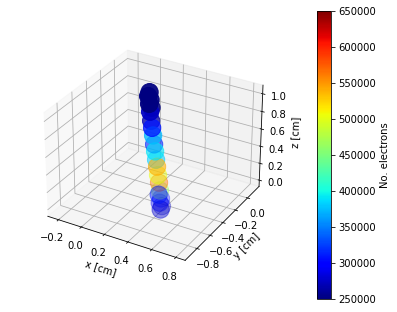

In [13]:
# plot a single track
track = tracks.iloc[2]
tracks
x,y,z,c = Reconst3D_v1(track.strips_x, track.strips_y, track.times_x, track.times_y, track.electrons_x, track.electrons_y,start=track.start,direction=track.direction, plot = True, save_name = "sim_alpha",plot_truth =False )


# Assess point resolution

In [14]:
def get_PR(tracks):

    # Analyze point resolution
    all_z = np.array([])
    all_x_err_1 = np.array([])
    all_y_err_1 = np.array([])
    all_x_err_2 = np.array([])
    all_y_err_2 = np.array([])



    for index, row in tracks.iterrows():

        try:
            x,y,z,c = Reconst3D_v1(row.strips_x, row.strips_y, row.times_x, row.times_y, row.electrons_x, row.electrons_y,start=row.start,direction=row.direction, plot = False, save_name = None)

            # Only consider tracks with 5 or more points
            if len(x) > 10:
                    
                # Get mismeasurements and absolute z values
                z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = GetTransErrs( x,y,z,c, charge_weighting = True)

                all_z = np.append(all_z,z_vals)
                all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
                all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
                all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
                all_y_err_2 = np.append(all_y_err_2,delta_ys_2)

        except:
            pass 


    # conver mismeaurments to cm 
    all_x_err_1 = all_x_err_1 * 10000
    all_y_err_1 = all_y_err_1 * 10000
    all_x_err_2 = all_x_err_2 * 10000
    all_y_err_2 = all_y_err_2 * 10000

    # Git mismeasurement versus abs. z using method 1
    abs_z, x_sigmas2, x_sigmas_err2, y_sigmas2, y_sigmas_err2, abs_z_std, x_std, y_std = Mismeasurment_vs_z(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, plot=False)




    plt.figure()
    plt.errorbar(abs_z,np.abs(x_sigmas2),x_sigmas_err2, color=colors["blue"],fmt='o',label="x strips", capthick=2)
    plt.errorbar(abs_z,np.abs(y_sigmas2),y_sigmas_err2, color=colors["red"],fmt='o',label="y strips", capthick=2)
    #plt.plot(abs_z_std,x_std,color=colors["blue"])
    #plt.plot(abs_z_std,y_std,color=colors["red"])
    plt.legend()
    plt.ylim((0,200))
    plt.xlabel("Abs. z [cm]")
    plt.ylabel("Effective Point Resolution [um]")
    plt.show()

    return np.abs(x_sigmas2), x_sigmas_err2, np.abs(y_sigmas2), y_sigmas_err2, abs_z

sigma x:  31.745696373167004 +/- 4.322662202515808
sigma y:  41.728271198420885 +/- 4.695756290301188
sigma x:  38.849980693990254 +/- 6.664037634477988
sigma y:  49.6388577361748 +/- 8.818084547125588
sigma x:  48.515565394260214 +/- 6.670217462017639
sigma y:  46.508849181512424 +/- 5.372602023243444
sigma x:  50.351713612047796 +/- 10.13973770453413
sigma y:  60.6178485395785 +/- 18.04638053460605
sigma x:  49.28676999011741 +/- 16.9038433071992
sigma y:  71.95309506710534 +/- 50.93357661885224
sigma x:  42.40080214991534 +/- 2.46164561731369
sigma y:  42.771462501233295 +/- 2.2895660743595196


/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in reciprocal


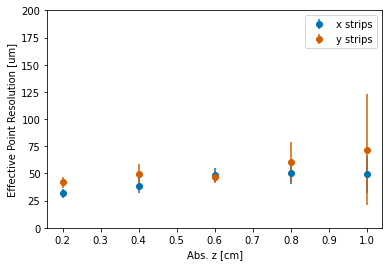

In [15]:
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks)

# Simulate Po210 in UH DLC Quadrant a



In [16]:
# Make dataframe to store all results

df_resolution = pd.DataFrame(columns = ['Name','x_res', 'x_res_err', 'y_res', 'y_res_err','abs_z'])

sigma x:  36.81296508973499 +/- 1.692675750807857
sigma y:  34.818167527903434 +/- 1.5630063768824507
sigma x:  40.78488265022715 +/- 1.6199843542014134
sigma y:  36.733403345698875 +/- 1.3339134350215722


/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in reciprocal


sigma x:  39.624886759671824 +/- 1.7293111542223678
sigma y:  34.74387268862973 +/- 1.297569666807929
sigma x:  38.18504552888926 +/- 2.069123635145146
sigma y:  42.381459771567286 +/- 2.2304738054889697
sigma x:  38.08332041544047 +/- 2.2767933227228307
sigma y:  46.93869818132783 +/- 5.112265801865376
sigma x:  39.33281155476751 +/- 0.7842904994501558
sigma y:  36.47481960891777 +/- 0.6878680451165249


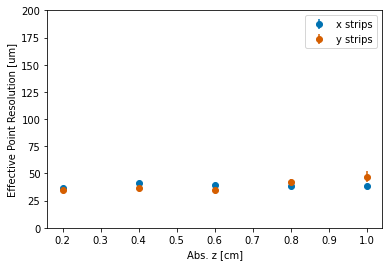

In [17]:
Charge_sharing = 0.41
Gain = 505.7
pitch_x = 0.02
pitch_y = 0.02

# simulatue tracks
tracks = sim_p210(n_sims = 500, theta_min = 5.0, theta_max = 25.0, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = 82/9.0*6241.5, thres_y =  82/4.5*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02)
tracks = pd.concat([tracks,hits],axis=1)

# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks)

df_resolution = df_resolution.append({'Name' : "UH_DLC_a", 'x_res' : x_res, 'x_res_err' : x_res_err, 'y_res' : y_res, 'y_res_err' :  y_res_err, 'abs_z' : abs_z }, ignore_index = True)



# Simulate Po210 in UH NoDLC Quadrant a

sigma x:  32.38863502972944 +/- 0.9563562456749662
sigma y:  34.58192873460171 +/- 1.0568391257202332
sigma x:  38.40841085137805 +/- 1.2590264946308618
sigma y:  38.56651760581156 +/- 1.2997815688684224
sigma x:  38.43268955666465 +/- 1.36251024274067
sigma y:  40.629723751948035 +/- 1.4485799312351726
sigma x:  40.19801519576783 +/- 1.5718120438680463
sigma y:  41.15202607879626 +/- 1.6988064295094638
sigma x:  49.68324230225077 +/- 2.6640134695826267
sigma y:  42.06841358841781 +/- 2.0933702925474664
sigma x:  38.899149426532595 +/- 0.6468565065457448
sigma y:  39.290265194533035 +/- 0.6423503419199529


/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in reciprocal
/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


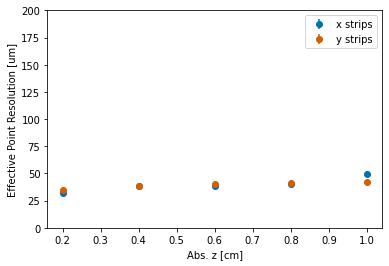

In [18]:
Charge_sharing = 0.62
Gain = 630.8
pitch_x = 0.02
pitch_y = 0.02

# simulatue tracks
tracks = sim_p210(n_sims = 500, theta_min = 5.0, theta_max = 25.0, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = 82/9.0*6241.5, thres_y =  82/4.5*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02)
tracks = pd.concat([tracks,hits],axis=1)

# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks)

df_resolution = df_resolution.append({'Name' : "UH_NoDLC_a", 'x_res' : x_res, 'x_res_err' : x_res_err, 'y_res' : y_res, 'y_res_err' :  y_res_err, 'abs_z' : abs_z }, ignore_index = True)



# Simulate Po210 in UoS

/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in reciprocal


sigma x:  35.214718906486404 +/- 1.4448466432196534
sigma y:  36.036992790854704 +/- 1.5751604644924642
sigma x:  42.34731899401239 +/- 1.8265719309955466
sigma y:  40.09353792321572 +/- 1.6757555681863825
sigma x:  43.10598096259531 +/- 2.0897066700176903
sigma y:  44.58064881450655 +/- 2.2350177169630485
sigma x:  44.83833805463167 +/- 1.838117147637424
sigma y:  45.939702708575 +/- 2.3883374764998186
sigma x:  51.58210650078392 +/- 2.159622428149033
sigma y:  52.64724350232048 +/- 2.284070745432105
sigma x:  41.63500660298261 +/- 0.7677913159016103
sigma y:  42.05597662872181 +/- 0.7873103341990049


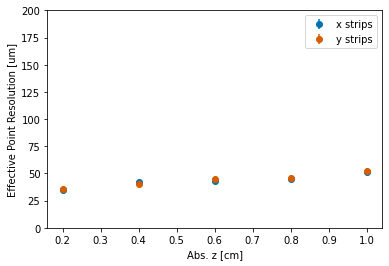

In [19]:
Charge_sharing = 0.13
Gain = 6490
pitch_x = 0.025
pitch_y = 0.025

# simulatue tracks
tracks = sim_p210(n_sims = 500, theta_min = 5.0, theta_max = 25.0, DL = 1.2, Diff = True, DTrans = 0.0135, DLong = 0.0129, W = 35.2)

# simulate readout
hits = sim_readout(tracks, peaking_time = 200, digit_t  = 250, pitch_x = pitch_x, pitch_y = pitch_y,thres_x = 82/9.0*6241.5, thres_y =  82/4.5*6241.5, CS = Charge_sharing, Gain = Gain, v_drift = 0.0008, Charge_integration = True, pitch_z = 0.02)
tracks = pd.concat([tracks,hits],axis=1)

# Reconstruct and get point resolutions
x_res, x_res_err, y_res, y_res_err, abs_z = get_PR(tracks)

df_resolution = df_resolution.append({'Name' : "UoS", 'x_res' : x_res, 'x_res_err' : x_res_err, 'y_res' : y_res, 'y_res_err' :  y_res_err, 'abs_z' : abs_z }, ignore_index = True)



In [20]:
df_resolution.to_pickle("./data/resolution_sim.pk")
df_resolution

,Name,x_res,x_res_err,y_res,y_res_err,abs_z
0,UH_DLC_a,"[36.81296508973499, 40.78488265022715, 39.6248...","[1.692675750807857, 1.6199843542014134, 1.7293...","[34.818167527903434, 36.733403345698875, 34.74...","[1.5630063768824507, 1.3339134350215722, 1.297...","[0.2, 0.4, 0.6, 0.8, 1.0]"
1,UH_NoDLC_a,"[32.38863502972944, 38.40841085137805, 38.4326...","[0.9563562456749662, 1.2590264946308618, 1.362...","[34.58192873460171, 38.56651760581156, 40.6297...","[1.0568391257202332, 1.2997815688684224, 1.448...","[0.2, 0.4, 0.6, 0.8, 1.0]"
2,UoS,"[35.214718906486404, 42.34731899401239, 43.105...","[1.4448466432196534, 1.8265719309955466, 2.089...","[36.036992790854704, 40.09353792321572, 44.580...","[1.5751604644924642, 1.6757555681863825, 2.235...","[0.2, 0.4, 0.6, 0.8, 1.0]"


# Appendix: Using charge-weighted std

In [13]:
# A function which bins missmeasurments in z and fits them to Gaussians, outputting the results
def Mismeasurment_vs_z_weighted( z_vals, x_mis , y_mis , charge, start = 0.1, stop = 1.0, step = 0.2):

    abs_z_std = []
    x_std_weighted = []
    y_std_weighted = []

    for z_low in np.arange(start,stop,step):

        #make data cut
        z_high = z_low + step
        data_cut = (z_vals > z_low) & (z_vals < z_high)

        x_temp = x_mis[data_cut]
        y_temp = y_mis[data_cut]
        charge_temp = charge[data_cut]
        #charge_temp = np.ones(len(x_temp))

        x_std_weighted += [np.sqrt(np.dot(x_temp*charge_temp,x_temp)/np.sum(charge_temp))]
        y_std_weighted += [np.sqrt(np.dot(y_temp*charge_temp,y_temp)/np.sum(charge_temp))]

        abs_z_std += [round( (z_low+z_high)/2.0 ,2)]


            


    return  abs_z_std, x_std_weighted, y_std_weighted



/Users/majdghrear/anaconda3/envs/my_root_env/lib/python3.7/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in reciprocal


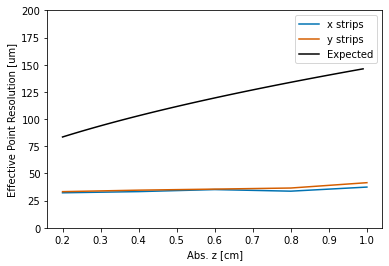

In [14]:
# Analyze point resolution
all_z = np.array([])
all_x_err_1 = np.array([])
all_y_err_1 = np.array([])
all_x_err_2 = np.array([])
all_y_err_2 = np.array([])

all_c = np.array([])



for index, row in tracks.iterrows():

    x,y,z,c = Reconst3D_v1(row.strips_x, row.strips_y, row.times_x, row.times_y, row.electrons_x, row.electrons_y,start=row.start,direction=row.direction, plot = False, save_name = None)

    # Only consider tracks with 5 or more points
    if len(x) > 5:
            
        # Get mismeasurements and absolute z values
        z_vals, delta_xs_1, delta_ys_1, delta_xs_2, delta_ys_2, v_PA, x_b = GetTransErrs( x,y,z,c, charge_weighting = True)

        all_z = np.append(all_z,z_vals)
        all_x_err_1 = np.append(all_x_err_1,delta_xs_1)
        all_y_err_1 = np.append(all_y_err_1,delta_ys_1)
        all_x_err_2 = np.append(all_x_err_2,delta_xs_2)
        all_y_err_2 = np.append(all_y_err_2,delta_ys_2)

        all_c = np.append(all_c,c)


# convert mismeaurments to cm 
all_x_err_1 = all_x_err_1 * 10000
all_y_err_1 = all_y_err_1 * 10000
all_x_err_2 = all_x_err_2 * 10000
all_y_err_2 = all_y_err_2 * 10000

# Git mismeasurement versus abs. z using method 1
abs_z_std, x_std, y_std = Mismeasurment_vs_z_weighted(z_vals=all_z, x_mis=all_x_err_2 , y_mis = all_y_err_2, charge = all_c)

x_ref = np.arange(0.2,1.0,0.01)
y_ref = np.sqrt( (pitch_x*10000/np.sqrt(12))**2 + (np.sqrt(x_ref)*DTrans*10000)**2 )


plt.figure()
plt.plot(abs_z_std,x_std,color=colors["blue"],label="x strips")
plt.plot(abs_z_std,y_std,color=colors["red"],label="y strips")
plt.plot(x_ref,y_ref,color=colors["black"],label="Expected")
plt.legend()
plt.ylim((0,200))
plt.xlabel("Abs. z [cm]")
plt.ylabel("Effective Point Resolution [um]")
plt.show()


Using a charge-weighted standard deviation agrees with the non-charge weighted standard deviation